## Tutorial 4: Advanced features
In this tutorial, you will learn:
* _How to intspect Rigetti's devices using Forest API_
* _Extract and interpret the information about decoherence of the qubits_
* _Usage of the server-side compiler_
* _How to incorporate noise models to estimate performance of the circuit on the real chip_

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

In [11]:
%matplotlib inline
!pip install --upgrade https://github.com/rigetticomputing/pyquil/archive/master.zip networkx matplotlib

    100% |████████████████████████████████| 45.0MB 16kB/s  eta 0:00:01    75% |████████████████████████        | 33.9MB 23.2MB/s eta 0:00:01
Requirement already up-to-date: networkx in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: matplotlib in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (from pyquil==2.0.0.dev0)
Requirement already up-to-date: antlr4-python3-runtime in /opt/conda/lib/python3.6/site-packages (from pyquil==2.0.0.dev0)
Requirement already up-to-date: requests in /opt/conda/lib/python3.6/site-packages (from pyquil==2.0.0.dev0)
Requirement already up-to-date: contextvars in /opt/conda/lib/python3.6/site-packages (from pyquil==2.0.0.dev0)
Requirement already up-to-date: six in /opt/conda/lib/python3.6/site-packages (from pyquil==2.0.0.dev0)
Requirement already up-to-date: decorator>=4.1.0 in /opt/conda/lib/python3.6/site-packages (from networkx)
Requirement already up-to-date

In [12]:
import os

API_KEY = ''
USER_ID = ''

PYQUIL_CONFIG = f"""
[Rigetti Forest]
url: https://api.rigetti.com/qvm
key: {API_KEY}
user_id: {USER_ID}
"""

with open(os.path.expanduser('~/.pyquil_config'), 'w') as f:
    f.write(PYQUIL_CONFIG)

### QPU status

The QPU devices can have different status and are not always immediatelly accessible. Luckily, you can inspect this information via Forest API.

#### Exercise 4.1
Use `pyquil.api` module to obtain list of available devices. Only list the devices that are currently online. What other states can devices be in?

In [39]:
import pyquil
devices = list(pyquil.api.get_devices(as_dict=True).values())
online_devices = [device for device in devices if device.is_online()]

print(f"All devices: {devices}")
print(f"Online devices: {online_devices}")

# Device can be in the online, offline or retuning state.

All devices: [<Device 8Q-Agave online>, <Device 19Q-Acorn offline>]
Online devices: [<Device 8Q-Agave online>]


### Chip topology

Knowing qubit topology of the chip you're working with is an important requirement to be able to design efficient circuits. Forest API provides an interface that exposes this information as well.


#### Exercise 4.2
Use <a href="https://pyquil.readthedocs.io/en/latest">Rigetti's documentation</a> to obtain and plot the topology of the `8Q-Agave` chip.

In [24]:
import pyquil
device = pyquil.api.get_devices(as_dict=True)['8Q-Agave']
data = device.isa.to_dict()
nodes = [key for key, value in data['1Q'].items()]
edges = [tuple(key.split('-')) for key, value in data['2Q'].items()]

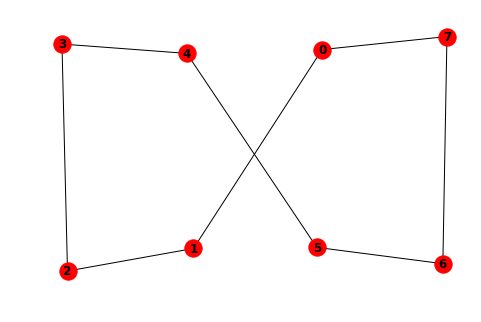

In [25]:
import networkx
G = networkx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
networkx.draw(G, with_labels=True, font_weight='bold')

#### Exercise 4.3
Rigetti also has a newer chip, called `19Q-Acorn`, which is currently offline (as you learned in the exercise 4.1) due to high number of malfunctioning qubits/couplings after a power outage incident. Obtain and plot the topology of the `19Q-Acorn` chip. Note that malfunctioning parts of the chip are marked as "dead", make sure to exclude those.

In [26]:
import pyquil
device = pyquil.api.get_devices(as_dict=True)['19Q-Acorn']
data = device.isa.to_dict()
nodes = [key for key, value in data['1Q'].items() if 'dead' not in value]
edges = [tuple(key.split('-')) for key, value in data['2Q'].items() if 'dead' not in value]

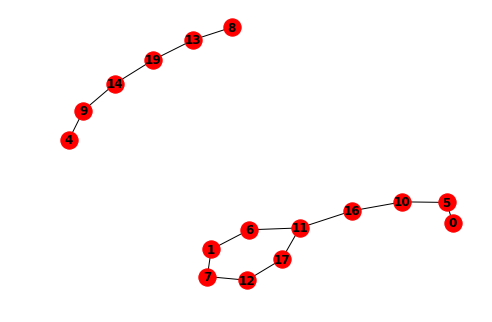

In [27]:
import networkx
G = networkx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
networkx.draw(G, with_labels=True, font_weight='bold')

### Decoherence and circuit depth

One of the main limiting factors if current near-term devices is actual decoherence of the qubits in the device. Decoherence can be loosely interpreted as loss of the quantum information in the qubit, and is caused by imperfections in the implementations of the quantum gates, or due to simple time-evolution of the system, as any current quantum chip is necessarily an open quantum system to a certain degree.

Generally, there are three sources of errors in the implementation of a given quantum circuit:
* actual qubit decoherence due to time-evolution (i.e. noise, interactions with environment)
* imprecise gate implementations (gates that do not have fidelities of 1)
* readout errors

#### T_1 and T_2 times
$T_1$ and $T_2$ relaxation times are one of the basic measures of performance of qubits in terms of decoherence. Roughly speaking:

* $T_1$ relaxation time (also called the "amplitude damping") is time during which the qubit decoheres from its excited state $\ket{1}$ to relaxed state $\ket{0}$.
* $T_2$ relaxation time (also called the "phase damping") can be measured using the following experiment: First you put the qubit into the superposition state $\frac{\ket{0}+\ket{1}}{\sqrt{2}}$ using a Hadamard gate, then you wait for $t_2$ and apply a Hadamard gate again. Without any noise, you would expect the state to be $\ket{0}$ again (remember $H^2 = I$), but if something caused the qubit to decohere to either $\ket{0}$ or $\ket{1}$ in the meantime, you will obtain the $\frac{\ket{0}\pm\ket{1}}{\sqrt{2}}$ instead.


#### Exercise 4.4

Use the device specifications of the $T_1$ times `8Q-Agave` chip obtained via the API, determine a simple upper bound on the single-qubit and two-qubit circuit depth on qubit 7 (assuming zero readout error and perfect-fidelity gates).

The average gate execution time of single qubit gate is 50ns and 150ns for the case of two-qubit gate.

In [55]:
import pyquil
device = pyquil.api.get_devices(as_dict=True)['8Q-Agave']
single_qubit_depth = device.specs.T1s()[7] / 50e-9
two_qubit_depth = device.specs.T1s()[7] / 150e-9
print(f"""
Single qubit gate depth: {single_qubit_depth:.0f}
Two qubit gate depth: {two_qubit_depth:.0f}
""")


Single qubit gate depth: 264
Two qubit gate depth: 88



#### Noise models
Simple estimation as given in the previous exercise provide a generous upper bound, since they neglect other source of errors in the computation, such as the readout errors or gate fidelities. To use a noise model, simply specify a device during definition of the QVMConnection object.

#### Exercise 4.5

Implement a simple circuit consisting of 20 alternating CNOT gates (swtiching between control qubit on 0 and 1). Empirically measure its performance (how many runs out of 1000 did not end up in the expected state).

In [70]:
import pyquil
from pyquil.quil import Program
from pyquil.gates import CNOT, MEASURE
program = Program(
    CNOT(i%2, (i+1)%2) for i in range(20)
) + Program(MEASURE(0, 0), MEASURE(1, 1))

device = pyquil.api.get_devices(as_dict=True)['8Q-Agave']
qvm = pyquil.api.QVMConnection(device=device)
results = qvm.run(program, trials=1000)
incorrect_results = [r for r in results if r != [0, 0]]
len(incorrect_results) / 1000

0.174

Increase the number of gates to 100 and then 200. How do you interpret the results?

### Manually triggered compilation

In the usual setting of submitting jobs to the QPU, the compilation is happening transparently, without the user of the Forest API needing to know that the circuit they constructed is decomposed into sequence of gate operations that are actually implemented on the hardware.

Similiarly, in order to accurately simulate the device with the noise, the circuits also have to be compiled to the fundamental gate set implemented by the chip, since those gates are the ones we have experimental information about.

Given both these cases, it is useful to be able to actually inspect and analyze the compiled version of the circuit - since that is what is exactly being run on the device.

#### Exercise 4.6

Compile circuit from the previous exercise using the CompilerConnection object. Inspect the compiler circuit, and figure out if anything is surprising. Contrast with the result of the previous exercise. Does this explain any surprising results?

Additionally, figure out the following parameters of the compiled circuit:
* gate depth
* two-qubit gate depth
* total number of gates used

In [86]:
import pyquil
from pyquil.api import CompilerConnection, get_devices
from pyquil.gates import CNOT

device = pyquil.api.get_devices(as_dict=True)['8Q-Agave']
compiler = pyquil.api.CompilerConnection(device=device)

program = Program(CNOT(i%2, (i+1)%2) for i in range(20))
job_id = compiler.compile_async(program)
job = compiler.wait_for_job(job_id)

print(job.compiled_quil())

job joxFSjiarDSkhPSu is currently compiling
PRAGMA EXPECTED_REWIRING "#(0 1 2 3 4 5 6 7)"
RZ(-1.5707963267948992) 0
RX(pi/2) 0
RZ(2.888982866515854) 0
RX(pi/2) 0
RZ(2.7749508004150574) 1
RX(1.5707963267948946) 1
CZ 0 1
RX(pi/2) 0
RX(-1.570796326794895) 1
CZ 0 1
RX(-pi/2) 0
RZ(-2.7749508004150574) 0
RZ(3.141592653589791) 1
RX(pi/2) 1
RZ(0.25260978707393816) 1
RX(-pi/2) 1
RZ(1.5707963267948977) 1
PRAGMA CURRENT_REWIRING "#(0 1 2 3 4 5 6 7)"
PRAGMA EXPECTED_REWIRING "#(0 1 2 3 4 5 6 7)"
PRAGMA CURRENT_REWIRING "#(0 1 2 3 4 5 6 7)"



In [90]:
print(f'''
Gate depth: {job.gate_depth()}
Multi-qubit gate depth: {job.multiqubit_gate_depth()}
Program fidelity: {job.program_fidelity():.3f}
''')


Gate depth: 12
Multi-qubit gate depth: 2
Program fidelity: 0.703



#### Exercise 4.7
Inspect the following circuit. Compile it to the `8Q-Agave` device. How does the compiled version differ from the uncompiled one?

```
H 2
H 4
H 7
CNOT 2 4
CNOT 4 7
CNOT 2 4
H 7
H 4
H 2
```

In [84]:
import pyquil
from pyquil.api import CompilerConnection, get_devices

device = pyquil.api.get_devices(as_dict=True)['8Q-Agave']
compiler = pyquil.api.CompilerConnection(device=device)

program = Program("""
H 2
H 4
H 7
CNOT 2 4
CNOT 4 7
CNOT 2 4
H 7
H 4
H 2
""")
job_id = compiler.compile_async(program, isa=device.isa)
job = compiler.wait_for_job(job_id)

print(job.compiled_quil())

job lHgXqzpnChxVdpEz is currently compiling
PRAGMA EXPECTED_REWIRING "#(0 1 3 2 4 6 7 5)"
RZ(pi/2) 3
RX(pi/2) 3
RX(-pi) 4
CZ 4 3
RZ(-pi/2) 4
RX(-pi/2) 4
RX(-pi) 5
CZ 5 4
RZ(-pi) 4
RX(pi/2) 4
CZ 4 3
RZ(-pi) 3
RX(pi/2) 3
RZ(pi/2) 3
RZ(pi/2) 4
RX(-pi) 4
RX(-pi) 5
PRAGMA CURRENT_REWIRING "#(0 1 3 2 4 6 7 5)"
PRAGMA EXPECTED_REWIRING "#(0 1 3 2 4 6 7 5)"
PRAGMA CURRENT_REWIRING "#(0 1 3 2 4 6 7 5)"

